# **Nowcasting UK Household Saving Ratio from Money & Credit Data using Mixed-data Sampling (MIDAS) Approach**
___

In [14]:
print(f'Latest Release Date: {SR_release}')
print(f'Latest Quarter Published on ONS Website: {test.dropna(subset=test.columns[2:2]).iloc[-1,0]}\n')
print(f'Next Release Date: {Next_release}')
print(f'Next Quarter to be Published: {test.iloc[-1,0]}')
print(f'Basic Nowcast (First Month only): {round(test.iloc[-1,6],3)}')
print(f'Balanced Nowcast (First Month only): {round(test.iloc[-1,7],3)}')
print(f'AR(1) Benchmark: {round(test.iloc[-1,8],3)}\n')
print('Errors:')
print(f'RMSE for Basic Nowcast (First Month only): {round(M1_rmse_simple,3)}')
print(f'RMSE for Balanced Nowcast (First Month only): {round(M1_rmse_balanced,3)}')
print(f'RMSE for AR(1) Benchmark: {round(rmse_ar,3)}')

Latest Release Date: 29-09-2023
Latest Quarter Published on ONS Website: 2023 Q3

Next Release Date: 28-12-2023
Next Quarter to be Published: 2023 Q3
Basic Nowcast (First Month only): 7.998
Balanced Nowcast (First Month only): 8.243
AR(1) Benchmark: 8.565

Errors:
RMSE for Basic Nowcast (First Month only): 2.285
RMSE for Balanced Nowcast (First Month only): 2.14
RMSE for AR(1) Benchmark: 3.519


---
## **Index**
- [Saving Ratio Description](#SR_Desc) 
- [Extracting Data from APIs](#Data)
- [Merge Dependent Variable with High-frequency Predictors](#Merge)
- [General MIDAS Methodology](#Methodology)
- Model 1 (AR-MIDAS with all 3 Monthly Predictors)
    - [Model Fitting, RMSEs, OLS Summary](#Model1Fit)
    - [Plot of Model 1 vs AR(1) Process](#Model1Plot)
    - [Model 1: Forecast for Next Quarter](#Model1Forecast)
- Model 2 (AR-MIDAS with only First Month Predictor)
    - [Model Fitting, RMSEs, OLS Summary](#Model2Fit)
    - [Plot of Model 2 vs AR(1) Process](#Model2Plot)
    - [Model 2: Forecast for Next Quarter](#Model2Forecast)
 - Further Readings
     - [MIDAS Framework](#MIDASread)
     - [References](#References)
___
Written by Victor Zommers | [Check out other notebooks](https://sites.google.com/view/victor-zommers/)

## **Abstract**
> This paper proposes an empirical method for Central Banks to contemporaneously estimate household savings from high-frequency banking statistics (without relying on survey or compensation data) through a parsimonious specification of U-MIDAS. 
>
>The Model outperforms Bank of England Forecast by reducing the out-of-sample RMSE by up to 50% without using regularisation techniques for variable selection. Depending on the model specification, the out-of-sample RMSE varies between 2.4 and 4.2 units of Saving Ratio, with residual standard errors of 1.1-1.6 unit. This research contributes to the latest trend in the statistical community towards the integration of money measurements into real-time macroeconomic projections.
>
>Further improvements were introduced in the full paper by considering different lag weight structures (Polynomial and Normalised Almon lags through MLE estimation) for predictors and different transformation techniques for limited dependent variable (Logit).

<a name="SR_Desc"></a>
## **Saving Ratio**
The household saving ratio (SR) equation is given by:
\begin{equation}
SR^{[1]}(\%) = \left( \frac{\text{Gross Disposable Income}^{[2]} - \text{Individual Consumption Expenditure}^{[3]}}{\text{Gross Disposable Income}^{[2]}} \right) \times 100
\end{equation}
ONS Series Codes:
[1] [DGD8](https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/dgd8/ukea)
[2] [RPQF](https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/rpqf/ukea)
[3] [ABJQ](https://www.ons.gov.uk/economy/nationalaccounts/satelliteaccounts/timeseries/abjq/qna)

Where:
> - Saving Ratio is bounded between 0% and 100% and represents contemporaneous distribution of households income between savings and consumption.
>
> - Gross Disposable Income is the amount of money that individuals in the household sector can spend or save after income distribution measures. It is the total of a households’ income from employment (wages, salaries self-employment earnings), property (interest, dividends) and current transfers received (social benefits, pensions), minus the direct and indirect taxes the households pay and the current transfers they provide (charitable donations, remittances to other households).
>
> - Individual Consumption Expenditure (equivalent to U.S. PCE) is the total value of all goods and services consumed by households and includes both discretionary and non-discretionary components.


<a name="Data"></a>
## **Import Packages**

In [1]:
import pandas as pd
import requests
import io
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning, module="statsmodels.tsa")
from sklearn.metrics import mean_squared_error

## **Fetch Quarterly Household Saving Rate from ONS**

In [2]:
url = "https://www.ons.gov.uk/generator?format=csv&uri=/economy/grossdomesticproductgdp/timeseries/dgd8/ukea"
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) ' 'AppleWebKit/537.36 (KHTML, like Gecko) ' 'Chrome/54.0.2840.90 ' 'Safari/537.36'}
response = requests.get(url, headers=headers)
df = pd.read_csv(io.StringIO(response.text))
SR_release = df.iloc[4,1]
Next_release = (datetime.strptime(SR_release, '%d-%m-%Y') + timedelta(days=90)).strftime('%d-%m-%Y')
df = df[df['Title'].str.contains(r'^\d{4} Q[1-4]$', na=False)]
df.columns = ['Quarter','SR']

# Add next quarter to store forecasted value
def next_quarter(quarter):
    year, q = quarter.split(' Q')
    if q == "4":
        return f"{int(year)+1} Q1"
    return f"{year} Q{int(q)+1}"
df.loc[df.index[-1] + 1] = [next_quarter(df['Quarter'].iloc[-1]), np.nan]
df.tail()

,Quarter,SR
305,2022 Q3,8.1
306,2022 Q4,8.7
307,2023 Q1,7.9
308,2023 Q2,9.1
309,2023 Q3,NaN


## **Fetch High-frequency Predictors from Bank of England Database**

In [3]:
boe_series = {'Datefrom':'01/Apr/1993','SeriesCodes':'LPMB3PS,LPMVQRR,LPMVVHR','CSVF':'TN','UsingCodes':'Y','VPD':'N','VFD':'N'}
url2 = 'http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes'
response = requests.get(url2, params=boe_series, headers=headers,verify = False)
df2 = pd.read_csv(io.BytesIO(response.content))
df2['DATE'] = pd.to_datetime(df2['DATE'],format='%d %b %Y')
def format_quarter_year(date):
    return f"{date.year} Q{date.quarter}"
df2['Quarter'] = df2['DATE'].apply(format_quarter_year)
df2.dropna(inplace=True)
df2.tail()

,DATE,LPMB3PS,LPMVQRR,LPMVVHR,Quarter
361,2023-05-31,1072,11267,1812229.0,2023 Q2
362,2023-06-30,1594,12537,1815587.0,2023 Q2
363,2023-07-31,1302,15777,1815927.0,2023 Q3
364,2023-08-31,1681,9247,1816218.0,2023 Q3
365,2023-09-30,1391,11563,1815204.0,2023 Q3


<a name="Merge"></a>
## **Merge Dependent Variable with High-frequency Predictors**
(Drop all quarters with missing/incomplete monthly observations, i.e. keep only Qs where 3/3 monthly obs. are available)

In [4]:
def pivot_on_column(df, df2, column_name):
    merged = pd.merge(df, df2, on='Quarter', how='left')
    merged['count'] = merged.groupby('Quarter').cumcount() + 1
    merged_pivot = merged.pivot(index='Quarter', columns='count', values=column_name)
    merged_pivot.columns = [f'{column_name}_1', f'{column_name}_2', f'{column_name}_3']
    return df.merge(merged_pivot, on='Quarter', how='left')

df = pivot_on_column(df, df2, 'LPMB3PS')
df = pivot_on_column(df, df2, 'LPMVQRR')
df = pivot_on_column(df, df2, 'LPMVVHR')
df['SR'] = pd.to_numeric(df['SR'], errors='coerce')
df['SR_Lag1'] = df['SR'].shift(1)
df['Date'] = pd.to_datetime(df['Quarter'].str.replace('Q1', '03-31').str.replace('Q2', '06-30').str.replace('Q3', '09-30').str.replace('Q4', '12-31'), format='%Y %m-%d')
df_M1 = df[['Quarter','SR','LPMB3PS_1','LPMVQRR_1','LPMVVHR_1','SR_Lag1','Date']].dropna(subset=['LPMB3PS_1', 'LPMVQRR_1', 'LPMVVHR_1'])
df.dropna(subset=df.columns[2:11], inplace=True)
df.tail()

,Quarter,SR,LPMB3PS_1,LPMB3PS_2,LPMB3PS_3,LPMVQRR_1,LPMVQRR_2,LPMVQRR_3,LPMVVHR_1,LPMVVHR_2,LPMVVHR_3,SR_Lag1,Date
238,2022 Q3,8.1,1522.0,993.0,755.0,6457.0,5316.0,6249.0,1788103.0,1792585.0,1800334.0,6.2,2022-09-30
239,2022 Q4,8.7,818.0,1451.0,854.0,12443.0,23404.0,11816.0,1806331.0,1811624.0,1813700.0,8.1,2022-12-31
240,2023 Q1,7.9,1628.0,1241.0,1598.0,10963.0,13421.0,13332.0,1816387.0,1816610.0,1812958.0,8.7,2023-03-31
241,2023 Q2,9.1,1594.0,1072.0,1594.0,24036.0,11267.0,12537.0,1816034.0,1812229.0,1815587.0,7.9,2023-06-30
242,2023 Q3,NaN,1302.0,1681.0,1391.0,15777.0,9247.0,11563.0,1815927.0,1816218.0,1815204.0,9.1,2023-09-30


<a name="Methodology"></a>
## **Reduced Form**
Let's denote the quarterly observations as $Y_q$ and the monthly observations as $X_m$. It means that for every quarter $_q$, the prediction is based on the three monthly observations within that quarter, with a maximum lag of 2 months, such that: $\forall Y_q,  \exists \{ X_{m}, X_{m-1}, X_{m-2} \}$.

The basic MIDAS regression for unrestricted lag structure is:
\begin{equation}Y_q = \alpha + \beta_0 X_{m} + \beta_1 X_{m-1} + \beta_2 X_{m-2} + \epsilon_q\end{equation}
Using sigma notation, this can be expressed as:
\begin{equation}Y_q = \alpha + \sum_{j=0}^{2} \beta_j X_{m-j} + \epsilon_q\end{equation}
This equation does not assume that the quarterly observation $Y_q$ is the sum of the monthly observations within that quarter. Instead, it models the quarterly observation as a function of the monthly observations within the quarter, with different weights $\beta_j$ assigned to each monthly observation and can be estimated directly via ordinary least squares (OLS).

This is equivalent to a lag structure $\texttt{mls(x,0:2,3)}$ in [$\texttt{midasr}$](https://cran.r-project.org/web/packages/midasr/index.html) package.


<a name="Model1Fit"></a>
## **Fitting Models**
- Do a 50/50 train-test split
- Fit a ***'basic' U-MIDAS*** with:
  - AR(1) Lag
  - Flows of Net Consumer Credit [LPMB3PS](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=&searchText=LPMB3PS)
- Fit a ***'balanced' U-MIDAS*** with:
  - AR(1) Lag
  - Flows of Net Consumer Credit [LPMB3PS](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=&searchText=LPMB3PS)
  - Flows of M4 Money Supply Holdings by Households [LPMVVHR](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=&searchText=LPMVVHR)
  - Cash Fiscal Deficit (commonly known as Public Sector Net Cash Requirement) [LPMVQRR](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=&searchText=LPMVQRR)
- Fit a ***recursive AR(1) Process*** as a benchmark
- Calculate RMSEs for all 3 models, drop last row if actual value is missing

In [5]:
# Train Test Split
train_size = int(len(df) * 0.5)
train, test = df.iloc[:train_size].copy(), df.iloc[train_size:].copy()
# Fit Basic U-MIDAS
y_train = train['SR']
X_train = train[['SR_Lag1', 'LPMB3PS_1', 'LPMB3PS_2', 'LPMB3PS_3']]
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
X_test = test[['SR_Lag1', 'LPMB3PS_1', 'LPMB3PS_2', 'LPMB3PS_3']]
X_test = sm.add_constant(X_test)
test['simple_forecast'] = model.predict(X_test)
# Fit Balanced U-MIDAS
X2_train = train[['SR_Lag1', 'LPMB3PS_1', 'LPMB3PS_2', 'LPMB3PS_3','LPMVQRR_1','LPMVQRR_2','LPMVQRR_3','LPMVVHR_1','LPMVVHR_2','LPMVVHR_3']]
X2_train = sm.add_constant(X2_train)
balanced_model = sm.OLS(y_train, X2_train).fit()
X2_test = test[['SR_Lag1', 'LPMB3PS_1', 'LPMB3PS_2', 'LPMB3PS_3','LPMVQRR_1','LPMVQRR_2','LPMVQRR_3','LPMVVHR_1','LPMVVHR_2','LPMVVHR_3']]
X2_test = sm.add_constant(X2_test)
test['balanced_forecast'] = balanced_model.predict(X2_test)
# Recursive AR(1) Forecasting
ar_predictions = []
for i in range(len(test)):
    temp_train = df.iloc[:train_size+i].copy()
    ar_model = ARIMA(temp_train['SR'], order=(1,0,0))
    ar_model_fit = ar_model.fit()
    forecast = ar_model_fit.forecast(steps=1).iloc[0]
    ar_predictions.append(forecast)
test['ar_forecast'] = ar_predictions
# Compute RMSE (remove last observation, if last Quarter is NA)
if pd.isna(test['SR'].iloc[-1]):
    rmse_simple = np.sqrt(mean_squared_error(test['SR'].iloc[:-1], test['simple_forecast'].iloc[:-1]))
    rmse_balanced = np.sqrt(mean_squared_error(test['SR'].iloc[:-1], test['balanced_forecast'].iloc[:-1]))
    rmse_ar = np.sqrt(mean_squared_error(test['SR'].iloc[:-1], test['ar_forecast'].iloc[:-1]))
else:
    rmse_simple = np.sqrt(mean_squared_error(test['SR'], test['simple_forecast']))
    rmse_balanced = np.sqrt(mean_squared_error(test['SR'], test['balanced_forecast']))
    rmse_ar = np.sqrt(mean_squared_error(test['SR'], test['ar_forecast']))
print(f'RMSE for basic U-MIDAS forecast: {rmse_simple}')
print(f'RMSE for balanced U-MIDAS forecast: {rmse_balanced}')
print(f'RMSE for AR(1) Process forecast: {rmse_ar}')
test.set_index('Date', inplace=True)

RMSE for basic U-MIDAS forecast: 2.5101431832078287
RMSE for balanced U-MIDAS forecast: 2.962086477035346
RMSE for AR(1) Process forecast: 3.5515430592928525


### **Print Summary for balanced or simple model to see which predictors are significant**

In [6]:
#print(model.summary())
print(balanced_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     SR   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     22.67
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           1.22e-13
Time:                        00:06:01   Log-Likelihood:                -57.902
No. Observations:                  52   AIC:                             137.8
Df Residuals:                      41   BIC:                             159.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2494      1.246      4.214      0.0

<a name="Model1Plot"></a>
### **Plot Fitted Values on a Graph**

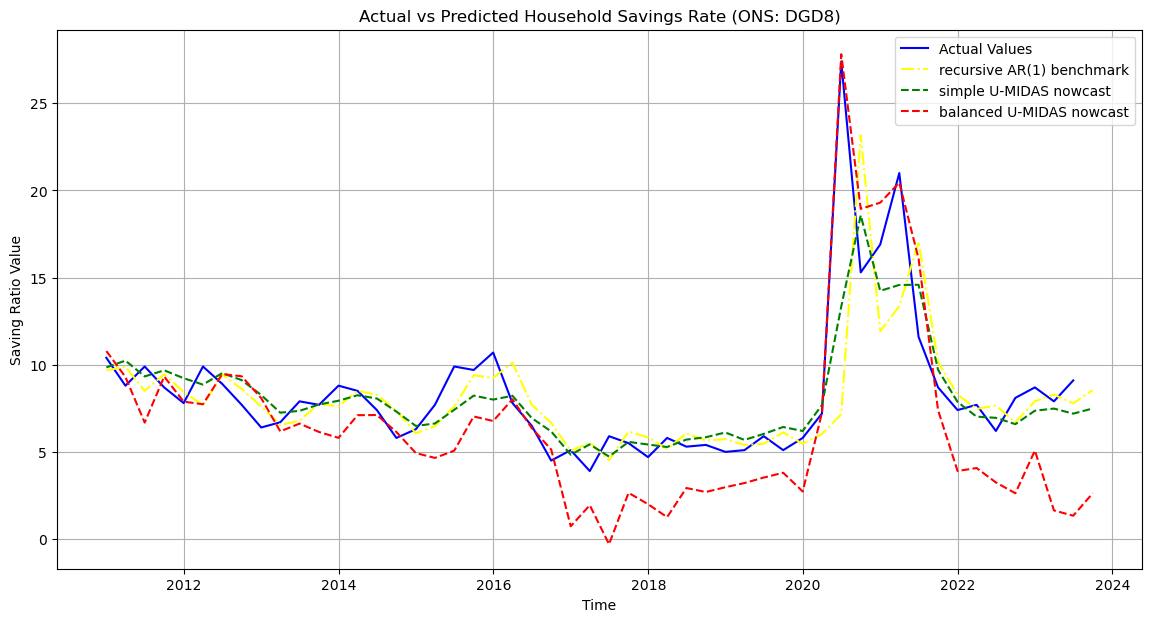

In [7]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['SR'], label='Actual Values', color='blue')
plt.plot(test['ar_forecast'], label='recursive AR(1) benchmark', color='yellow', linestyle='-.')
plt.plot(test['simple_forecast'], label='simple U-MIDAS nowcast', color='green', linestyle='--')
plt.plot(test['balanced_forecast'], label='balanced U-MIDAS nowcast', color='red', linestyle='--')
plt.title('Actual vs Predicted Household Savings Rate (ONS: DGD8)')
plt.xlabel('Time')
plt.ylabel('Saving Ratio Value')
plt.legend()
plt.grid(True)
plt.show()

<a name="Model1Forecast"></a>
### **Print Forecast for Next Quarter**

In [8]:
test[['Quarter','SR','simple_forecast','balanced_forecast','ar_forecast']].tail()

,Quarter,SR,simple_forecast,balanced_forecast,ar_forecast
Date,,,,,
2022-09-30,2022 Q3,8.1,6.591255,2.625150,6.701298
2022-12-31,2022 Q4,8.7,7.362557,5.075253,7.906015
2023-03-31,2023 Q1,7.9,7.484493,1.641566,8.289560
2023-06-30,2023 Q2,9.1,7.194718,1.337879,7.784813
2023-09-30,2023 Q3,NaN,7.490203,2.625125,8.548822


In [9]:
print(f'Latest Release Date: {SR_release}')
print(f'Latest Quarter Published on ONS Website: {test.dropna(subset=test.columns[2:2]).iloc[-1,0]}\n')
print(f'Next Release Date: {Next_release}')
print(f'Next Quarter to be Published: {test.iloc[-1,0]}')
print(f'Basic Nowcast: {round(test.iloc[-1,6],3)}')
print(f'Balanced Nowcast: {round(test.iloc[-1,7],3)}')
print(f'AR(1) Benchmark: {round(test.iloc[-1,8],3)}\n')
print('Errors:')
print(f'RMSE for Basic Nowcast: {round(rmse_simple,3)}')
print(f'RMSE for Balanced Nowcast: {round(rmse_balanced,3)}')
print(f'RMSE for AR(1) Benchmark: {round(rmse_ar,3)}')

Latest Release Date: 29-09-2023
Latest Quarter Published on ONS Website: 2023 Q3

Next Release Date: 28-12-2023
Next Quarter to be Published: 2023 Q3
Basic Nowcast: 9247.0
Balanced Nowcast: 11563.0
AR(1) Benchmark: 1815927.0

Errors:
RMSE for Basic Nowcast: 2.51
RMSE for Balanced Nowcast: 2.962
RMSE for AR(1) Benchmark: 3.552


<a name="Model2Fit"></a>
## **Nowcast Quarter only with the first Month**
We are using **```df_m1```** dataframe here instead, where we dropped only missing First Month Observations.

In [10]:
# Train Test Split (We need to reestimate it for df_M1 dataframe)
train_size = int(len(df_M1) * 0.5)
train, test = df_M1.iloc[:train_size].copy(), df_M1.iloc[train_size:].copy()
# Fit Basic U-MIDAS, but only first month
y_train = train['SR']
X_train = train[['SR_Lag1', 'LPMB3PS_1']]
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
X_test = test[['SR_Lag1', 'LPMB3PS_1']]
X_test = sm.add_constant(X_test)
test['M1_simple_forecast'] = model.predict(X_test)
# Fit Balanced U-MIDAS, but only first month
X2_train = train[['SR_Lag1', 'LPMB3PS_1','LPMVQRR_1','LPMVVHR_1']]
X2_train = sm.add_constant(X2_train)
balanced_model = sm.OLS(y_train, X2_train).fit()
X2_test = test[['SR_Lag1', 'LPMB3PS_1','LPMVQRR_1','LPMVVHR_1']]
X2_test = sm.add_constant(X2_test)
test['M1_balanced_forecast'] = balanced_model.predict(X2_test)
# Recursive AR(1) Forecasting, exactly same as before
ar_predictions = []
for i in range(len(test)):
    # Note that we changed df to df_M1 in recursive AR as well
    temp_train = df_M1.iloc[:train_size+i].copy()
    ar_model = ARIMA(temp_train['SR'], order=(1,0,0))
    ar_model_fit = ar_model.fit()
    forecast = ar_model_fit.forecast(steps=1).iloc[0]
    ar_predictions.append(forecast)
test['ar_forecast'] = ar_predictions
# Compute RMSE (remove last observation, if last Quarter is NA)
if pd.isna(test['SR'].iloc[-1]):
    M1_rmse_simple = np.sqrt(mean_squared_error(test['SR'].iloc[:-1], test['M1_simple_forecast'].iloc[:-1]))
    M1_rmse_balanced = np.sqrt(mean_squared_error(test['SR'].iloc[:-1], test['M1_balanced_forecast'].iloc[:-1]))
    rmse_ar = np.sqrt(mean_squared_error(test['SR'].iloc[:-1], test['ar_forecast'].iloc[:-1]))
else:
    M1_rmse_simple = np.sqrt(mean_squared_error(test['SR'], test['M1_simple_forecast']))
    M1_rmse_balanced = np.sqrt(mean_squared_error(test['SR'], test['M1_balanced_forecast']))
    rmse_ar = np.sqrt(mean_squared_error(test['SR'], test['ar_forecast']))
print(f'RMSE for basic U-MIDAS forecast using First month: {M1_rmse_simple}')
print(f'RMSE for balanced U-MIDAS forecast using First month: {M1_rmse_balanced}')
print(f'RMSE for AR(1) Process forecast: {rmse_ar}')
test.set_index('Date', inplace=True)

RMSE for basic U-MIDAS forecast using First month: 2.2849225791648875
RMSE for balanced U-MIDAS forecast using First month: 2.1403735812977
RMSE for AR(1) Process forecast: 3.518681911553417


> We can see somewhat better RMSEs, when compared with MIDAS models (where all 3 monthly observations are used).

<a name="Model2Plot"></a>
### Plotting Nowcast by using only First Month of Quarter

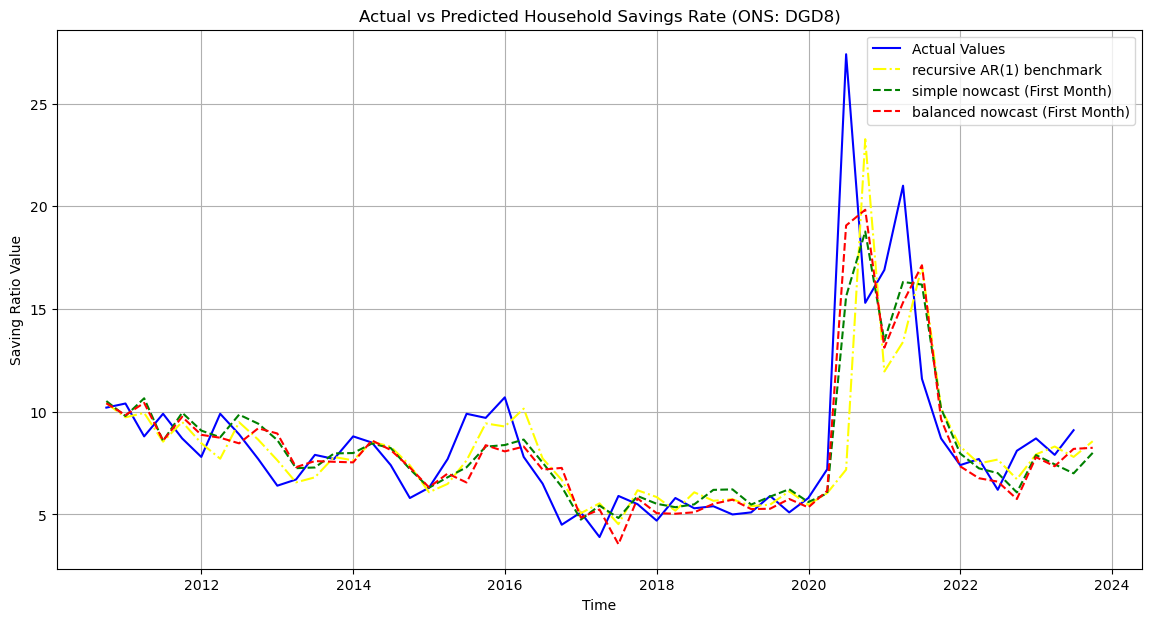

In [11]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['SR'], label='Actual Values', color='blue')
plt.plot(test['ar_forecast'], label='recursive AR(1) benchmark', color='yellow', linestyle='-.')
plt.plot(test['M1_simple_forecast'], label='simple nowcast (First Month)', color='green', linestyle='--')
plt.plot(test['M1_balanced_forecast'], label='balanced nowcast (First Month)', color='red', linestyle='--')
plt.title('Actual vs Predicted Household Savings Rate (ONS: DGD8)')
plt.xlabel('Time')
plt.ylabel('Saving Ratio Value')
plt.legend()
plt.grid(True)
plt.show()

### Print Forecast for Next Quarter from only First Month
<a name="Model2Forecast"></a>

In [12]:
test[['Quarter','SR','M1_simple_forecast','M1_balanced_forecast','ar_forecast']].tail()

,Quarter,SR,M1_simple_forecast,M1_balanced_forecast,ar_forecast
Date,,,,,
2022-09-30,2022 Q3,8.1,6.072071,5.751424,6.716535
2022-12-31,2022 Q4,8.7,7.890353,7.788492,7.922258
2023-03-31,2023 Q1,7.9,7.438365,7.346033,8.305964
2023-06-30,2023 Q2,9.1,7.001230,8.191657,7.800566
2023-09-30,2023 Q3,NaN,7.997894,8.243450,8.565040


In [13]:
print(f'Latest Release Date: {SR_release}')
print(f'Latest Quarter Published on ONS Website: {test.dropna(subset=test.columns[2:2]).iloc[-1,0]}\n')
print(f'Next Release Date: {Next_release}')
print(f'Next Quarter to be Published: {test.iloc[-1,0]}')
print(f'Basic Nowcast (First Month only): {round(test.iloc[-1,6],3)}')
print(f'Balanced Nowcast (First Month only): {round(test.iloc[-1,7],3)}')
print(f'AR(1) Benchmark: {round(test.iloc[-1,8],3)}\n')
print('Errors:')
print(f'RMSE for Basic Nowcast (First Month only): {round(M1_rmse_simple,3)}')
print(f'RMSE for Balanced Nowcast (First Month only): {round(M1_rmse_balanced,3)}')
print(f'RMSE for AR(1) Benchmark: {round(rmse_ar,3)}')

Latest Release Date: 29-09-2023
Latest Quarter Published on ONS Website: 2023 Q3

Next Release Date: 28-12-2023
Next Quarter to be Published: 2023 Q3
Basic Nowcast (First Month only): 7.998
Balanced Nowcast (First Month only): 8.243
AR(1) Benchmark: 8.565

Errors:
RMSE for Basic Nowcast (First Month only): 2.285
RMSE for Balanced Nowcast (First Month only): 2.14
RMSE for AR(1) Benchmark: 3.519


<a name="MIDASread"></a>
## **Further Readings**

### **Mixed-Frequency Data Sampling (MIDAS) Method**

Mixed-Frequency Data Sampling (MIDAS) method was proposed in Ghysels,Santa-Clara, and Valkanov (2004)[[1]](#ref1), which formalised a theoretical framework that allows for estimation of small number of hyperparameters from predictor space with mixed-dimensionality. The method gained great prominence due to its parsimony in construction, flexibility in lag structure, and ease of forecast estimation.

MIDAS allows for a great degree of flexibility in method, ranging from Unrestricted specification (U-MIDAS), that does not make any parametric assumptions regarding lag structure of predictors, to non-linear parameterisation of the weights (Almon polynomial or Beta lags), normalised lags (adding up to 1) for robustness or any combination of above.

The method instantly gained prominence among professional forecasters, as the early 2000s saw a rapid rise in the volume of public statistics available for analysis. This gave an opportunity to combine high-frequency data from diverse sources at diverse frequencies to predict low-frequency data (primarily using monthly data to estimate quarterly variables like GDP).

Clements and Galvão (2008)[[2]](#ref2) demonstrated that AR-MIDAS outperforms Vector Autoregression (VAR) method near one quarter horizon for US GDP estimation, when using monthly data. Kuzin, Marcellino, and Schumacher (2011)[[3]](#ref3) demonstrated similar results for nowcasting of GDP growth in Euro area with MIDAS outperforming mixed-frequency VAR for short horizons (up to 5 months). In addition, MIDAS method quickly became predominant in financial econometrics, due to the abundance of high-frequency asset pricing data and is primarily applied towards estimation of volatility through GARCH-MIDAS specification. For example, Ghysels, Santa-Clara, and Valkanov (2006)[[4]](#ref4) followed-up with empirical application of MIDAS to predict implied volatility from daily and intra-day stock returns. Conrad, Custovic, Ghysels (2018)[[5]](#ref5) further applied GARCH-MIDAS to examine financial and macroeconomic determinants of Bitcoin volatility.

While other alternative methods exist for addressing mixed frequencies in nowcasts, like simple interpolation in Fernández (1981)[[6]](#ref6), or Dynamic Factor Model through State-Space approach with Kalman filter, **all of them rely on treating low-frequency data, as if it existed but was missing**. Bai, Ghysels, and Wright (2013)[[7]](#ref7) compared differences between MIDAS and Kalman filter and found that **MIDAS is less prone to parameter estimation error or misspecification, while being much less computationally demanding**.

MIDAS is favoured in ML-Ops due to its linear relationship structure, even though it incorporates potentially nonlinear parameters through its weighting scheme. This linear foundation facilitates ease of interpretation within machine learning frameworks, while the nonlinear weighting offers flexibility in capturing mixed-frequency data dynamics. In addition, its linear framework permits the application of regularisation techniques (e.g. Lasso and Ridge), thereby optimising the model and preventing overfitting in scenarios with abundant predictors. However, stationarity testing is often violated in such setups. Babii, Ghysels, Striaukas (2021)[[8]](#ref8) further examined LASSO-MIDAS through the proprietary `midasml` R package and found that it performs better at nowcasting US GDP, relative to the New York Fed's Dynamic Factor Models.

Prior work by Ghysels, Kvedaras, Zemlys (2016)[[9]](#ref9) resulted in the development of the `midasr` package, which enables general estimation of MIDAS in R. Due to inherent noise in money & credit predictors, regularisation might amplify the impact of this noise by trying to fit an incorrect model that is more influenced by the noisy observations. For example, during the variable selection stage, a persistent correlation of Houshold Saving Ratio with Overdraft interest rate [IUMODTL](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=&searchText=IUMODTL) was found, however after further investigation it appears that the series is graphically similar to a logistic function with no real explanatory power.

<a name="References"></a>
### **References**

<a id="ref1"></a>[1] Ghysels, Eric and Santa-Clara, Pedro and Valkanov, Rossen. *The MIDAS touch: Mixed data sampling regression models*, 2004.

<a id="ref2"></a>[2] Clements, Michael P and Galvão, Ana Beatriz. *Macroeconomic forecasting with mixed-frequency data: Forecasting output growth in the United States*. Journal of Business & Economic Statistics, 2008.

<a id="ref3"></a>[3] Kuzin, Vladimir and Marcellino, Massimiliano and Schumacher, Christian. *MIDAS vs. mixed-frequency VAR: Nowcasting GDP in the euro area*. International Journal of Forecasting, 2011.

<a id="ref4"></a>[4] Ghysels, Eric and Santa-Clara, Pedro and Valkanov, Rossen. *Predicting volatility: getting the most out of return data sampled at different frequencies*. Journal of Econometrics, 2006.

<a id="ref5"></a>[5] Conrad, Christian and Custovic, Anessa and Ghysels, Eric. *Long-and short-term cryptocurrency volatility components: A GARCH-MIDAS analysis*. Journal of Risk and Financial Management, 2018.

<a id="ref6"></a>[6] Fernandez, Roque B. *A methodological note on the estimation of time series*. The Review of Economics and Statistics, 1981.

<a id="ref7"></a>[7] Bai, Jennie and Ghysels, Eric and Wright, Jonathan H. *State space models and MIDAS regressions*. Econometric Reviews, 2013.

<a id="ref8"></a>[8] Babii, Andrii and Ghysels, Eric and Striaukas, Jonas. *Machine learning time series regressions with an application to nowcasting Online Appendix*, 2021.

<a id="ref9"></a>[9] Ghysels, Eric and Kvedaras, Virmantas and Zemlys, Vaidotas. *Mixed frequency data sampling regression models: the R package midasr*. Journal of statistical software, 2016.